In [45]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr
import numpy as np
from scipy.stats import zscore
from scipy.special import logit
from IPython.core.pylabtools import figsize

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
from tqdm import tqdm

In [28]:
# data_dir = '/mnt/lareaulab/cfbuenabadn/data_sc_regulation/data_autocorrelation/'
data_dir = '../../data/'
tiklova_mrna_event = pd.read_csv(data_dir + 'tiklova_neurogenesis/mrna_per_event.tab', sep='\t', index_col=0)
tiklova_neurogenesis_rd = pd.read_csv(data_dir + 'tiklova_neurogenesis/rd_pc2.tab', sep='\t', index_col=0)
tiklova_PSI = pd.read_csv(data_dir + 'tiklova_neurogenesis/skipped_exons_psi.tab', sep='\t', index_col=0)
tiklova_psix = pd.read_csv('../psix_runs/tiklova_neurogenesis.scores.txt', sep='\t', index_col=0)
tiklova_cross_psix = pd.read_csv('../psix_runs/tiklova_neurogenesis.cross_scores.tab', sep='\t', index_col=0)
# tiklova_kw = pd.read_csv('~/sc_splicing_regulation/sc_neurogenesis/tiklova_neurogenesis_kw.tab', sep='\t', index_col=0)
tiklova_kw = pd.read_csv(data_dir + 'tiklova_neurogenesis/tiklova_neurogenesis_kw.tab', sep='\t', index_col=0)

In [5]:
def get_ranks(scores_df, score_name, bins=50):
    score_series = scores_df.sort_values(score_name).sort_values(score_name)
    ranks_dict = dict()
    total_exons = len(scores_df.index)
    exons_per_rank = int(total_exons/bins)
    for i in range(bins):
        bin_str = i+1
        bin_lims = -exons_per_rank*i
        if i == bins - 1:
            rank_exons = scores_df.sort_values(score_name).index[:bin_lims]
        elif i == 0:
            rank_exons = scores_df.sort_values(score_name).index[bin_lims-exons_per_rank:]
        else:
            
            rank_exons = scores_df.sort_values(score_name).index[bin_lims-exons_per_rank:bin_lims]
        ranks_dict.update({bin_str:rank_exons})
    return ranks_dict
    

def make_comparison(df1, df2, score1, score2, bins=50):
    
    rank_df = pd.DataFrame()
    rank_df_exons = pd.DataFrame()
    
    ranks1 = get_ranks(df1, score1, bins)
    ranks2 = get_ranks(df2, score2, bins)
    
    for i in range(1, bins+1):
        shared_list = []
        shared_exons_list = []
        r1_i = ranks1[i]
        for j in range(1, bins+1):
            r2_j = ranks2[j]
            
            shared = len(r1_i & r2_j)
            
            shared_list.append(len(r1_i & r2_j))
            shared_exons_list.append(r1_i & r2_j)
            
        rank_df['bin_' + str(i)] = shared_list
        rank_df_exons['bin_' + str(i)] = shared_exons_list
        
    rank_df.index = ['bin_' + str(i) for i in range(1, bins+1)]
    rank_df_exons.index = ['bin_' + str(i) for i in range(1, bins+1)]
    
    return rank_df, rank_df_exons
        

In [10]:
comparison

,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,bin_10,bin_11,bin_12,bin_13,bin_14,bin_15,bin_16,bin_17,bin_18,bin_19,bin_20
bin_1,74,18,5,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
bin_2,22,41,19,8,6,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0
bin_3,0,23,23,25,14,8,4,1,0,0,0,0,0,0,0,0,1,0,0,0
bin_4,1,7,22,20,18,11,6,6,3,0,0,0,1,1,0,1,1,0,1,0
bin_5,2,6,10,14,14,13,14,4,5,5,3,3,2,1,1,0,0,0,1,1
bin_6,0,0,9,10,15,13,9,10,7,6,4,2,4,2,3,1,1,1,1,1
bin_7,0,2,6,5,7,13,11,10,13,7,3,4,3,1,5,2,1,3,2,1
bin_8,0,2,1,4,5,9,12,10,8,14,7,2,5,4,3,4,3,2,3,1
bin_9,0,0,1,4,5,6,5,11,12,7,12,3,7,4,4,7,3,2,4,2
bin_10,0,0,0,2,2,6,8,5,11,6,15,8,4,8,9,7,4,1,1,2


In [13]:
mask

,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,bin_10,bin_11,bin_12,bin_13,bin_14,bin_15,bin_16,bin_17,bin_18,bin_19,bin_20
bin_1,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
bin_2,False,False,False,False,False,False,False,True,True,False,True,True,True,True,True,True,True,True,True,True
bin_3,True,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,False,True,True,True
bin_4,False,False,False,False,False,False,False,False,False,True,True,True,False,False,True,False,False,True,False,True
bin_5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False
bin_6,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bin_7,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bin_8,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bin_9,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bin_10,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


Text(50.0, 0.5, 'Psix ranks')

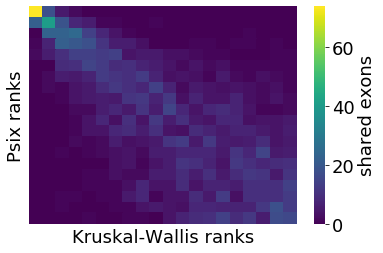

In [21]:
comparison, comparison_exons = make_comparison(tiklova_kw.loc[tiklova_psix.index], tiklova_psix.loc[tiklova_psix.index],
                             'KW_score', 'L_score', bins=20)
mask = comparison == 0
                             
# g = sns.heatmap(comparison, mask=mask, cmap='viridis', cbar_kws={'label': 'shared exons'}, 
g = sns.heatmap(comparison, cmap='viridis', cbar_kws={'label': 'shared exons'}, 
                yticklabels=False, xticklabels=False)
g.set_facecolor('lightgray')

# g.tick_params(labelsize=0)
g.figure.axes[-1].tick_params(labelsize=18)
g.figure.axes[-1].yaxis.label.set_size(18)

plt.xlabel('Kruskal-Wallis ranks', fontsize=18)
plt.ylabel('Psix ranks', fontsize=18)

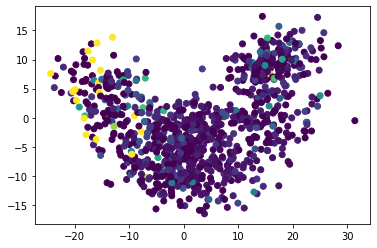

In [7]:
# Exon good for Psix, not for KW
plt.scatter(tiklova_neurogenesis_rd.PC_1, tiklova_neurogenesis_rd.PC_2, 
            c=tiklova_PSI.loc['Snhg11_nmdSE_1', tiklova_neurogenesis_rd.index])

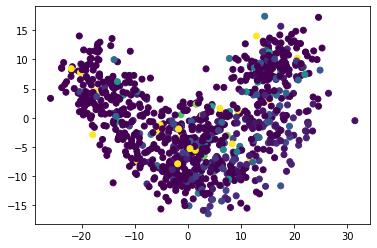

In [7]:
# Exon good for KW, not for Psix
plt.scatter(tiklova_neurogenesis_rd.PC_1, tiklova_neurogenesis_rd.PC_2, 
            c=tiklova_PSI.loc['Syt1_3', tiklova_neurogenesis_rd.index])

In [24]:
weyn_pvals = pd.read_csv(data_dir + 'weyn/Weyn_pvals.tab', sep='\t', index_col=0)
weyn_fdr = pd.read_csv(data_dir + 'weyn/Weyn_fdr.tab', sep='\t', index_col=0)
weyn_psi = pd.read_csv(data_dir + 'weyn/Weyn_psi.tab', sep='\t', index_col=0)

In [57]:
def L_upgma_step(cross_L_matrix, score_min = 0.1):
#     score_min = 0.1
    counter = 1
    for exon in cross_L_matrix.index:
        exon_max = cross_L_matrix.loc[exon].dropna().sort_values().index[-1]
        exon_pair = (exon, exon_max)
        pair_score = cross_L_matrix.loc[exon, exon_max]
        pair_score_r = cross_L_matrix.loc[exon_max, exon]
        if counter == 1:
            max_pair = exon_pair
            max_pair_score = pair_score
            max_pair_score_r = pair_score_r
        else:
            token_1 = (pair_score > max_pair_score) and (pair_score_r >= score_min)
            token_2 = (pair_score >= score_min) and (pair_score_r >= score_min) and (max_pair_score_r < score_min)
            if token_1 or token_2:
                max_pair = (exon, exon_max)
                max_pair_score = cross_L_matrix.loc[exon, exon_max]
                max_pair_score_r = cross_L_matrix.loc[exon_max, exon]
        counter += 1

    if (max_pair_score >= score_min) and (max_pair_score_r >= score_min):
        new_idx = [x for x in cross_L_matrix.index if x not in max_pair]
        new_df = cross_L_matrix.loc[new_idx, new_idx]

        combined_cross_1 = cross_L_matrix.loc[new_idx, list(max_pair)].mean(axis=1)
        combined_cross_2 = cross_L_matrix.loc[list(max_pair), new_idx].mean(axis=0)

        new_df[','.join(max_pair)] = combined_cross_2
        new_df = new_df.T
        new_df[','.join(max_pair)] = list(combined_cross_1) + [0]
        new_df = new_df.T
        
        return new_df
    else:
        print(max_pair_score)
        return [0]
            
            
def get_modules(cross_L_matrix, score_min = 0.0):
    counter = 1
    for i in tqdm(range(len(cross_L_matrix.index))):
        combined_cross = L_upgma_step(cross_L_matrix, score_min)
        if len(combined_cross) == 1:
            return cross_L_matrix
        else:
            cross_L_matrix = combined_cross
            
#         print(counter)
    return cross_L_matrix
        
    
    
        
    #print(cross_L_matrix.loc[exon].dropna().sort_values().index[-1])

In [58]:
x = tiklova_psix.sort_values('L_score')[-200:].index
modules_psix = get_modules(tiklova_cross_psix.loc[x, x])

100%|██████████| 200/200 [01:49<00:00,  1.83it/s]


In [59]:
modules_psix

,Gria2_nmdSE_2,Igsf9_1,"Rps6kb2_nmdSE_1,Epha5_3,Pdlim7_8","Ap2a1_2,Atxn7l1_2","P4htm_1,Las1l_2,Cadm1_4","Emc10_7,Emc10_7,Tecr_6","Dnajc5_nmdSE_1,Chl1_4,Peg3_nmdSE_1,Atp6v1h_5,Rsrp1_2,Ntan1_1,Map4_15,Morf4l2_7,Morf4l2_7,Sugp2_10,Nnat_3,Nnat_2,Nnat_2,Meg3_2","Clasp1_17,Apip_1,Stk38_5","Pdlim7_9,Cadm3_1,Add1_2,Lrsam1_3,Dtnb_16,Dtnb_16","Ntan1_9,Ntan1_8,Ntan1_8","Kcnip1_1,Cadps_2,Lrrfip2_7,Srsf9_nmdSE_1,Kif3a_1,Mapt_1,Dst_5,Gabrg2_1,Ndrg4_1,Ndrg4_1,Dbn1_1,C2cd5_4,Spag9_6,Dst_6,Tpd52_2,Stxbp1_2,Clta_4,Mprip_7,Kcnq2_8,Rbm3_nmdSE_1,Ablim2_6,Ncam1_6,Spag9_12,Prpf18_1,Mapt_3,Sh3kbp1_1,C2cd5_2,Micu1_4,Micu1_4,Dync1i2_1,Clstn1_2,Dync1i2_4,Gphn_7,Cog1_1","Atxn2_5,H13_6,Ppip5k2_4","Tsg101_4,Zfp811_1,Zfp811_1,Dlg1_10,Lrrcc1_2,Nap1l4_18,Ank2_11,Map4_12,Nnat_6,Nnat_6,Ttc3_11,Mapk8ip3_13","Fez2_1,Epn2_8,Pak3_7,Pak3_7","Osbpl9_10,Fbxw11_1,Fbxw11_1","Aplp2_2,Aplp2_2","Ldhb_1,Nup54_1,Dpf2_2,Ndufa6_1,Arfgap1_7,Aplp2_3,Lysmd4_3,Eif4a2_6,Clk1_1,Nfasc_9,Ap1b1_4,Wdr7_1,Mff_4,Mars_3,Dclk2_3,Rnf14_6,Trappc9_1,G3bp2_4,Cltb_2,Sorbs1_13,Mff_8,Clta_1,Camk2g_2,Kifap3_1,Kif1b_8,Sgip1_4,Rpn2_3,Zfp207_1,Nrcam_8,Camk2g_7,Adgrl2_16,Cldnd1_4,Tpd52l2_3,Cldnd1_2,Cldnd1_3,Slc30a9_1,Ccdc85a_3,Slc30a9_2,Sorbs1_11,Cd200_1,Camk2d_5,Fam168a_7,Ank2_9,Lrrfip1_8","Nr2c2ap_1,Kif21a_12,Abi2_2,Snrpa1_2,Rnf114_1,Cadm1_10,Mbnl1_6,Add1_4,Kif3a_3,Sorbs2_15,Usp34_5,Clasp1_16,Sorbs2_18,Mbnl2_2,Supt5_5,Cadm1_3,Tom1l2_1,Elmo2_2,Nova1_1,Mbnl2_1,Mbnl2_1,Ctnna2_3,Dusp11_1,Caly_1,Gtf2a2_4,Ssbp3_3,Erc2_6,Tcf25_3,Klc1_2,Dlg2_4,Ybx1_1,Ablim2_4,Resp18_1","Ttc3_23,Ttc3_23,Wbp2_2,Wbp2_2","Cuta_1,Cuta_1,Bnip2_nmdSE_1,Cnot2_nmdSE_1,Sbf1_3,Ank2_3,Pqlc1_3,Xpa_nmdSE_1,Dclk1_1,Ndrg2_2,Ndrg2_2,Epb41l3_5,Plpp1_1,Tacc2_4,Pfkp_4,Golga2_2,Atg16l1_4,Elavl2_8,Cadps_7,Map2_4,Uqcr10_1,Gapvd1_5,Mff_5,Nrcam_3,Ppp3ca_3,Fnbp1l_3,Fnbp1l_3,Kif1a_5,Fnbp1l_4,Fnbp1l_4,Ogdh_5,Calu_nmdSE_2,Cnot2_nmdSE_2,Bin1_1,Ppfia4_4,Srsf9_2,Srsf9_nmdSE_2,Lrrfip2_5,Lrrfip2_5,Dnm1l_3,Nktr_nmdSE_2,Plpp1_2"
Gria2_nmdSE_2,0.065000,-0.020000,-0.048250,-0.151500,-0.091500,0.001000,0.032500,-0.096750,-0.012000,0.014000,-0.091969,-0.053500,0.001687,-0.085250,-0.062000,-0.040000,-0.085134,-0.101914,0.014000,-0.048161
Igsf9_1,-0.069000,0.067000,-0.090750,-0.101500,-0.001750,-0.021500,0.013906,0.023250,0.020875,0.038000,-0.060546,-0.103500,0.025906,-0.060500,-0.085500,-0.162000,-0.108390,0.019994,0.054000,-0.065917
"Rps6kb2_nmdSE_1,Epha5_3,Pdlim7_8",-0.100750,-0.116500,0.000000,0.051000,-0.010938,-0.045625,-0.065352,-0.125938,-0.077875,-0.106000,0.010042,0.046813,-0.084008,0.021437,0.050000,0.057750,0.041129,-0.070169,-0.150625,0.011212
"Ap2a1_2,Atxn7l1_2",-0.026500,-0.082000,0.022750,0.000000,-0.012000,-0.074500,-0.071703,-0.233250,-0.129812,-0.128750,-0.053990,0.024250,-0.097703,-0.000500,0.032750,0.029500,0.047860,-0.134981,-0.190750,0.014520
"P4htm_1,Las1l_2,Cadm1_4",-0.054750,0.004750,0.006063,-0.053375,0.000000,-0.084500,-0.009742,-0.014875,0.008125,0.006250,-0.119947,-0.007875,0.012406,0.000375,-0.066750,-0.000250,-0.042261,0.031237,0.003500,-0.030888
"Emc10_7,Emc10_7,Tecr_6",0.035000,0.008000,-0.040500,-0.056500,-0.087500,0.000000,0.058125,0.004500,0.003625,0.026250,-0.055814,-0.027375,0.019688,-0.084000,-0.031500,-0.051500,-0.022699,-0.012120,0.020750,-0.034369
"Dnajc5_nmdSE_1,Chl1_4,Peg3_nmdSE_1,Atp6v1h_5,Rsrp1_2,Ntan1_1,Map4_15,Morf4l2_7,Morf4l2_7,Sugp2_10,Nnat_3,Nnat_2,Nnat_2,Meg3_2",0.015969,-0.015187,-0.054914,-0.103156,-0.007477,0.050078,0.000000,-0.013336,0.002484,0.025156,-0.112234,-0.050047,0.053381,-0.101992,-0.045734,-0.019094,-0.052323,0.005795,0.005812,-0.050594
"Clasp1_17,Apip_1,Stk38_5",-0.037500,0.018750,-0.130500,-0.196875,-0.020000,-0.002750,0.003102,0.000000,0.039688,0.048000,-0.195228,-0.113625,0.026094,-0.087375,-0.139000,-0.115000,-0.160344,0.050333,0.020000,-0.156675
"Pdlim7_9,Cadm3_1,Add1_2,Lrsam1_3,Dtnb_16,Dtnb_16",-0.043500,-0.004125,-0.075406,-0.132812,0.013844,-0.002750,-0.001824,0.050750,0.000000,0.053000,-0.121015,-0.041938,0.033793,-0.083813,-0.110375,-0.097250,-0.120965,0.065193,0.019625,-0.150561
"Ntan1_9

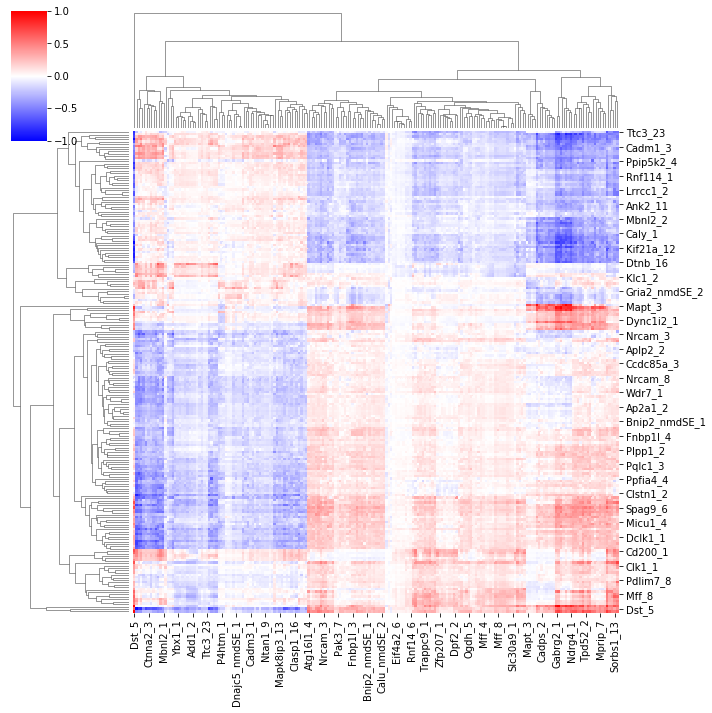

In [39]:
sns.clustermap(tiklova_cross_psix.loc[x, x], vmin=-1, vmax=1, cmap='bwr')

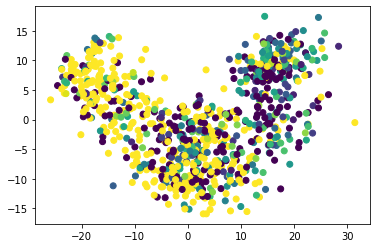

In [56]:
# Exon good for KW, not for Psix
plt.scatter(tiklova_neurogenesis_rd.PC_1, tiklova_neurogenesis_rd.PC_2, 
            c=tiklova_PSI.loc['Ntan1_9', tiklova_neurogenesis_rd.index])

In [60]:
# css_out = get_modules(cross_super_sig, 0.01)
clusters = {}
counter = 0
for cluster in modules_psix.index:
    if len(cluster.split(',')) >= 10:
        clusters.update({counter:cluster.split(',')})
        counter += 1

In [64]:
clusters

{0: ['Dnajc5_nmdSE_1',
  'Chl1_4',
  'Peg3_nmdSE_1',
  'Atp6v1h_5',
  'Rsrp1_2',
  'Ntan1_1',
  'Map4_15',
  'Morf4l2_7',
  'Morf4l2_7',
  'Sugp2_10',
  'Nnat_3',
  'Nnat_2',
  'Nnat_2',
  'Meg3_2'],
 1: ['Kcnip1_1',
  'Cadps_2',
  'Lrrfip2_7',
  'Srsf9_nmdSE_1',
  'Kif3a_1',
  'Mapt_1',
  'Dst_5',
  'Gabrg2_1',
  'Ndrg4_1',
  'Ndrg4_1',
  'Dbn1_1',
  'C2cd5_4',
  'Spag9_6',
  'Dst_6',
  'Tpd52_2',
  'Stxbp1_2',
  'Clta_4',
  'Mprip_7',
  'Kcnq2_8',
  'Rbm3_nmdSE_1',
  'Ablim2_6',
  'Ncam1_6',
  'Spag9_12',
  'Prpf18_1',
  'Mapt_3',
  'Sh3kbp1_1',
  'C2cd5_2',
  'Micu1_4',
  'Micu1_4',
  'Dync1i2_1',
  'Clstn1_2',
  'Dync1i2_4',
  'Gphn_7',
  'Cog1_1'],
 2: ['Tsg101_4',
  'Zfp811_1',
  'Zfp811_1',
  'Dlg1_10',
  'Lrrcc1_2',
  'Nap1l4_18',
  'Ank2_11',
  'Map4_12',
  'Nnat_6',
  'Nnat_6',
  'Ttc3_11',
  'Mapk8ip3_13'],
 3: ['Ldhb_1',
  'Nup54_1',
  'Dpf2_2',
  'Ndufa6_1',
  'Arfgap1_7',
  'Aplp2_3',
  'Lysmd4_3',
  'Eif4a2_6',
  'Clk1_1',
  'Nfasc_9',
  'Ap1b1_4',
  'Wdr7_1',
  'Mff_4',

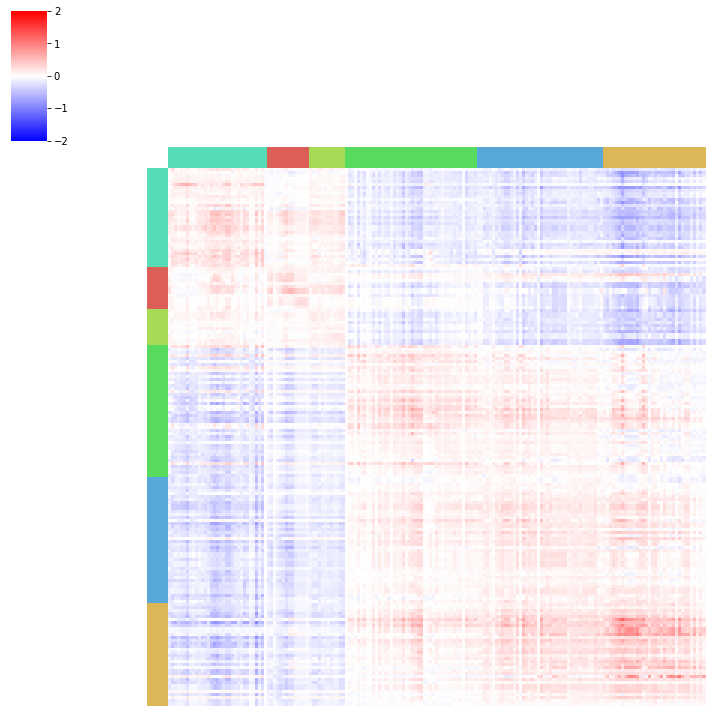

In [69]:
exons_list = []
# for i in range(len(clusters.keys())):
for i in [4, 0, 2, 3, 5, 1]:
    exons_list.extend(clusters[i])
    
colores = sns.color_palette("hls", 9)
exons_list = []
color_list = []
for i in [4, 0, 2, 3, 5, 1]:
    exons_list.extend(clusters[i])
    color_list.extend([colores[i]]*len(clusters[i]))
    
sns.clustermap(tiklova_cross_psix.loc[exons_list, exons_list], col_cluster=False, row_cluster=False,
               col_colors=color_list, row_colors = color_list, cmap='bwr', vmin=-2, vmax=2,
              yticklabels=0, xticklabels=0)

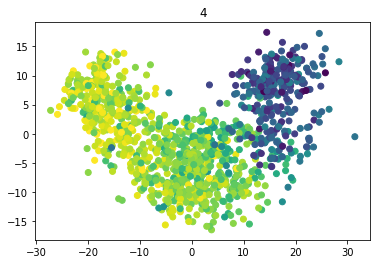

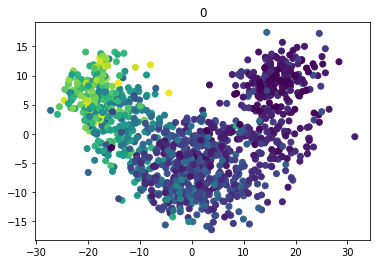

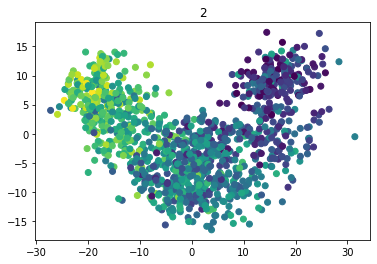

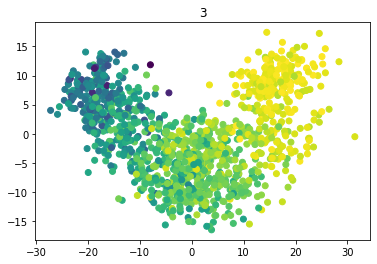

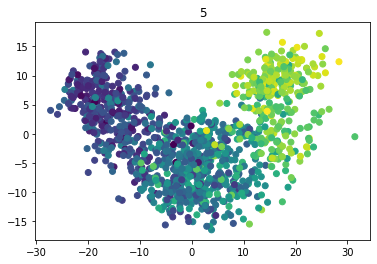

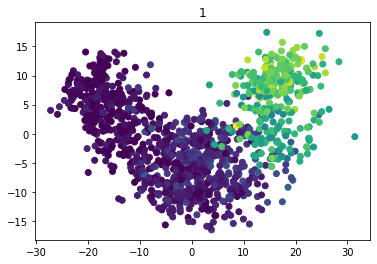

In [82]:
for i in [4, 0, 2, 3, 5, 1]:
    plt.scatter(tiklova_neurogenesis_rd.PC_1, tiklova_neurogenesis_rd.PC_2, 
                c = tiklova_PSI.loc[clusters[i]].mean(axis=0))
    plt.title(i)
    plt.show()

In [63]:
exons_list

['Dnajc5_nmdSE_1',
 'Chl1_4',
 'Peg3_nmdSE_1',
 'Atp6v1h_5',
 'Rsrp1_2',
 'Ntan1_1',
 'Map4_15',
 'Morf4l2_7',
 'Morf4l2_7',
 'Sugp2_10',
 'Nnat_3',
 'Nnat_2',
 'Nnat_2',
 'Meg3_2',
 'Kcnip1_1',
 'Cadps_2',
 'Lrrfip2_7',
 'Srsf9_nmdSE_1',
 'Kif3a_1',
 'Mapt_1',
 'Dst_5',
 'Gabrg2_1',
 'Ndrg4_1',
 'Ndrg4_1',
 'Dbn1_1',
 'C2cd5_4',
 'Spag9_6',
 'Dst_6',
 'Tpd52_2',
 'Stxbp1_2',
 'Clta_4',
 'Mprip_7',
 'Kcnq2_8',
 'Rbm3_nmdSE_1',
 'Ablim2_6',
 'Ncam1_6',
 'Spag9_12',
 'Prpf18_1',
 'Mapt_3',
 'Sh3kbp1_1',
 'C2cd5_2',
 'Micu1_4',
 'Micu1_4',
 'Dync1i2_1',
 'Clstn1_2',
 'Dync1i2_4',
 'Gphn_7',
 'Cog1_1',
 'Tsg101_4',
 'Zfp811_1',
 'Zfp811_1',
 'Dlg1_10',
 'Lrrcc1_2',
 'Nap1l4_18',
 'Ank2_11',
 'Map4_12',
 'Nnat_6',
 'Nnat_6',
 'Ttc3_11',
 'Mapk8ip3_13',
 'Ldhb_1',
 'Nup54_1',
 'Dpf2_2',
 'Ndufa6_1',
 'Arfgap1_7',
 'Aplp2_3',
 'Lysmd4_3',
 'Eif4a2_6',
 'Clk1_1',
 'Nfasc_9',
 'Ap1b1_4',
 'Wdr7_1',
 'Mff_4',
 'Mars_3',
 'Dclk2_3',
 'Rnf14_6',
 'Trappc9_1',
 'G3bp2_4',
 'Cltb_2',
 'Sorbs1_13',
 

In [ ]:
sns.clustermap(tiklova_cross_L.loc[exons_list, exons_list], col_cluster=False, row_cluster=False,
               col_colors=color_list, row_colors = color_list, cmap='bwr', vmin=-2, vmax=2,
              yticklabels=0, xticklabels=0)